In [2]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt

from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR, SVR
from sklearn.metrics import mean_absolute_error
pd.options.display.precision = 15

import lightgbm as lgb
import xgboost as xgb
import time
import datetime
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
import gc
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from scipy.signal import hilbert
from scipy.signal import hann
from scipy.signal import convolve
from scipy import stats
from sklearn.kernel_ridge import KernelRidge

In [3]:
%matplotlib inline

In [4]:
%%time
train_df = pd.read_csv('../input/train/train.csv', dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32})

CPU times: user 2min 19s, sys: 8.59 s, total: 2min 28s
Wall time: 2min 34s


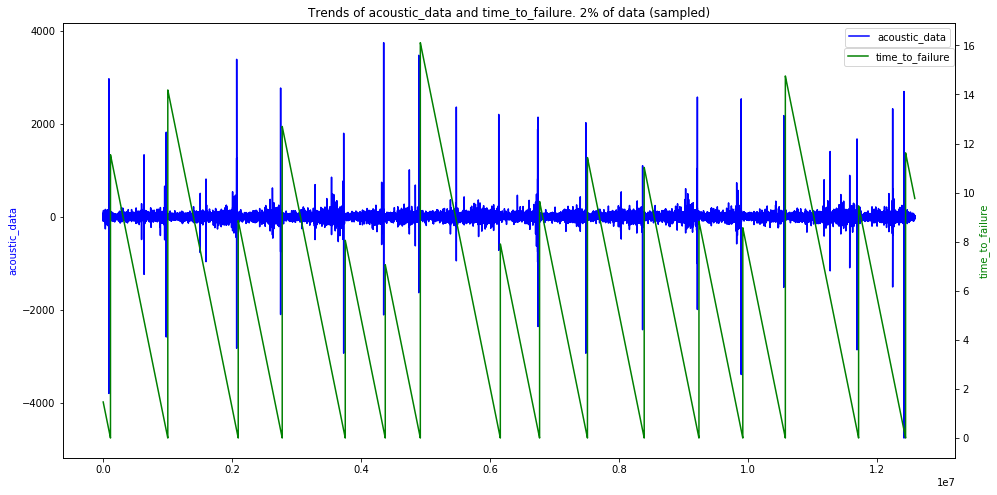

In [5]:
train_acoustic_data_small = train_df['acoustic_data'].values[::50]
train_time_to_failure_small = train_df['time_to_failure'].values[::50]

fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("Trends of acoustic_data and time_to_failure. 2% of data (sampled)")
plt.plot(train_acoustic_data_small, color='b')
ax1.set_ylabel('acoustic_data', color='b')
plt.legend(['acoustic_data'])
ax2 = ax1.twinx()
plt.plot(train_time_to_failure_small, color='g')
ax2.set_ylabel('time_to_failure', color='g')
plt.legend(['time_to_failure'], loc=(0.875, 0.9))
plt.grid(False)

del train_acoustic_data_small
del train_time_to_failure_small

In [6]:
gc.collect()

16

In [19]:
rows = 15000
segments = train_df.shape[0] // rows

In [20]:
print(segments)

41943


In [21]:
#rows = 150_000
#segments = int(np.floor(train_df.shape[0] / rows))

def add_trend_feature(arr, abs_values=False):
    idx = np.array(range(len(arr)))
    if abs_values:
        arr = np.abs(arr)
    lr = LinearRegression()
    lr.fit(idx.reshape(-1, 1), arr)
    return lr.coef_[0]

def classic_sta_lta(x, length_sta, length_lta):
    
    sta = np.cumsum(x ** 2)

    # Convert to float
    sta = np.require(sta, dtype=np.float)

    # Copy for LTA
    lta = sta.copy()

    # Compute the STA and the LTA
    sta[length_sta:] = sta[length_sta:] - sta[:-length_sta]
    sta /= length_sta
    lta[length_lta:] = lta[length_lta:] - lta[:-length_lta]
    lta /= length_lta

    # Pad zeros
    sta[:length_lta - 1] = 0

    # Avoid division by zero by setting zero values to tiny float
    dtiny = np.finfo(0.0).tiny
    idx = lta < dtiny
    lta[idx] = dtiny

    return sta / lta

X_tr = pd.DataFrame(index=range(segments), dtype=np.float64)

y_tr = pd.DataFrame(index=range(segments), dtype=np.float64, columns=['time_to_failure'])

total_mean = train_df['acoustic_data'].mean()
total_std = train_df['acoustic_data'].std()
total_max = train_df['acoustic_data'].max()
total_min = train_df['acoustic_data'].min()
total_sum = train_df['acoustic_data'].sum()
total_abs_sum = np.abs(train_df['acoustic_data']).sum()

def calc_change_rate(x):
    change = (np.diff(x) / x[:-1]).values
    change = change[np.nonzero(change)[0]]
    change = change[~np.isnan(change)]
    change = change[change != -np.inf]
    change = change[change != np.inf]
    return np.mean(change)

for segment in tqdm_notebook(range(segments)):
    seg = train_df.iloc[segment*rows:segment*rows+rows]
    x = pd.Series(seg['acoustic_data'].values)
    y = seg['time_to_failure'].values[-1]
    
    y_tr.loc[segment, 'time_to_failure'] = y
    X_tr.loc[segment, 'mean'] = x.mean()
    X_tr.loc[segment, 'std'] = x.std()
    X_tr.loc[segment, 'max'] = x.max()
    X_tr.loc[segment, 'min'] = x.min()
    
    X_tr.loc[segment, 'mean_change_abs'] = np.mean(np.diff(x))
    X_tr.loc[segment, 'mean_change_rate'] = calc_change_rate(x)
    X_tr.loc[segment, 'abs_max'] = np.abs(x).max()
    X_tr.loc[segment, 'abs_min'] = np.abs(x).min()
    
    X_tr.loc[segment, 'std_first_50000'] = x[:50000].std()
    X_tr.loc[segment, 'std_last_50000'] = x[-50000:].std()
    X_tr.loc[segment, 'std_first_10000'] = x[:10000].std()
    X_tr.loc[segment, 'std_last_10000'] = x[-10000:].std()
    
    X_tr.loc[segment, 'avg_first_50000'] = x[:50000].mean()
    X_tr.loc[segment, 'avg_last_50000'] = x[-50000:].mean()
    X_tr.loc[segment, 'avg_first_10000'] = x[:10000].mean()
    X_tr.loc[segment, 'avg_last_10000'] = x[-10000:].mean()
    
    X_tr.loc[segment, 'min_first_50000'] = x[:50000].min()
    X_tr.loc[segment, 'min_last_50000'] = x[-50000:].min()
    X_tr.loc[segment, 'min_first_10000'] = x[:10000].min()
    X_tr.loc[segment, 'min_last_10000'] = x[-10000:].min()
    
    X_tr.loc[segment, 'max_first_50000'] = x[:50000].max()
    X_tr.loc[segment, 'max_last_50000'] = x[-50000:].max()
    X_tr.loc[segment, 'max_first_10000'] = x[:10000].max()
    X_tr.loc[segment, 'max_last_10000'] = x[-10000:].max()
    
    X_tr.loc[segment, 'max_to_min'] = x.max() / np.abs(x.min())
    X_tr.loc[segment, 'max_to_min_diff'] = x.max() - np.abs(x.min())
    X_tr.loc[segment, 'count_big'] = len(x[np.abs(x) > 500])
    X_tr.loc[segment, 'sum'] = x.sum()
    
    X_tr.loc[segment, 'mean_change_rate_first_50000'] = calc_change_rate(x[:50000])
    X_tr.loc[segment, 'mean_change_rate_last_50000'] = calc_change_rate(x[-50000:])
    X_tr.loc[segment, 'mean_change_rate_first_10000'] = calc_change_rate(x[:10000])
    X_tr.loc[segment, 'mean_change_rate_last_10000'] = calc_change_rate(x[-10000:])
    
    X_tr.loc[segment, 'q95'] = np.quantile(x, 0.95)
    X_tr.loc[segment, 'q99'] = np.quantile(x, 0.99)
    X_tr.loc[segment, 'q05'] = np.quantile(x, 0.05)
    X_tr.loc[segment, 'q01'] = np.quantile(x, 0.01)
    
    X_tr.loc[segment, 'abs_q95'] = np.quantile(np.abs(x), 0.95)
    X_tr.loc[segment, 'abs_q99'] = np.quantile(np.abs(x), 0.99)
    X_tr.loc[segment, 'abs_q05'] = np.quantile(np.abs(x), 0.05)
    X_tr.loc[segment, 'abs_q01'] = np.quantile(np.abs(x), 0.01)
    
    X_tr.loc[segment, 'trend'] = add_trend_feature(x)
    X_tr.loc[segment, 'abs_trend'] = add_trend_feature(x, abs_values=True)
    X_tr.loc[segment, 'abs_mean'] = np.abs(x).mean()
    X_tr.loc[segment, 'abs_std'] = np.abs(x).std()
    
    X_tr.loc[segment, 'mad'] = x.mad()
    X_tr.loc[segment, 'kurt'] = x.kurtosis()
    X_tr.loc[segment, 'skew'] = x.skew()
    X_tr.loc[segment, 'med'] = x.median()
    
    X_tr.loc[segment, 'Hilbert_mean'] = np.abs(hilbert(x)).mean()
    X_tr.loc[segment, 'Hann_window_mean'] = (convolve(x, hann(150), mode='same') / sum(hann(150))).mean()
    X_tr.loc[segment, 'classic_sta_lta1_mean'] = classic_sta_lta(x, 500, 10000).mean()
    X_tr.loc[segment, 'classic_sta_lta2_mean'] = classic_sta_lta(x, 5000, 100000).mean()
    X_tr.loc[segment, 'classic_sta_lta3_mean'] = classic_sta_lta(x, 3333, 6666).mean()
    X_tr.loc[segment, 'classic_sta_lta4_mean'] = classic_sta_lta(x, 10000, 25000).mean()
    X_tr.loc[segment, 'classic_sta_lta5_mean'] = classic_sta_lta(x, 50, 1000).mean()
    X_tr.loc[segment, 'classic_sta_lta6_mean'] = classic_sta_lta(x, 100, 5000).mean()
    X_tr.loc[segment, 'classic_sta_lta7_mean'] = classic_sta_lta(x, 333, 666).mean()
    X_tr.loc[segment, 'classic_sta_lta8_mean'] = classic_sta_lta(x, 4000, 10000).mean()
    X_tr.loc[segment, 'Moving_average_700_mean'] = x.rolling(window=700).mean().mean(skipna=True)
    ewma = pd.Series.ewm
    X_tr.loc[segment, 'exp_Moving_average_300_mean'] = (ewma(x, span=300).mean()).mean(skipna=True)
    X_tr.loc[segment, 'exp_Moving_average_3000_mean'] = ewma(x, span=3000).mean().mean(skipna=True)
    X_tr.loc[segment, 'exp_Moving_average_30000_mean'] = ewma(x, span=30000).mean().mean(skipna=True)
    no_of_std = 3
    X_tr.loc[segment, 'MA_700MA_std_mean'] = x.rolling(window=700).std().mean()
    X_tr.loc[segment,'MA_700MA_BB_high_mean'] = (X_tr.loc[segment, 'Moving_average_700_mean'] + no_of_std * X_tr.loc[segment, 'MA_700MA_std_mean']).mean()
    X_tr.loc[segment,'MA_700MA_BB_low_mean'] = (X_tr.loc[segment, 'Moving_average_700_mean'] - no_of_std * X_tr.loc[segment, 'MA_700MA_std_mean']).mean()
    X_tr.loc[segment, 'MA_400MA_std_mean'] = x.rolling(window=400).std().mean()
    X_tr.loc[segment,'MA_400MA_BB_high_mean'] = (X_tr.loc[segment, 'Moving_average_700_mean'] + no_of_std * X_tr.loc[segment, 'MA_400MA_std_mean']).mean()
    X_tr.loc[segment,'MA_400MA_BB_low_mean'] = (X_tr.loc[segment, 'Moving_average_700_mean'] - no_of_std * X_tr.loc[segment, 'MA_400MA_std_mean']).mean()
    X_tr.loc[segment, 'MA_1000MA_std_mean'] = x.rolling(window=1000).std().mean()
    X_tr.drop('Moving_average_700_mean', axis=1, inplace=True)
    
    X_tr.loc[segment, 'iqr'] = np.subtract(*np.percentile(x, [75, 25]))
    X_tr.loc[segment, 'q999'] = np.quantile(x,0.999)
    X_tr.loc[segment, 'q001'] = np.quantile(x,0.001)
    X_tr.loc[segment, 'ave10'] = stats.trim_mean(x, 0.1)

    for windows in [10, 100, 1000]:
        x_roll_std = x.rolling(windows).std().dropna().values
        x_roll_mean = x.rolling(windows).mean().dropna().values
        
        X_tr.loc[segment, 'ave_roll_std_' + str(windows)] = x_roll_std.mean()
        X_tr.loc[segment, 'std_roll_std_' + str(windows)] = x_roll_std.std()
        X_tr.loc[segment, 'max_roll_std_' + str(windows)] = x_roll_std.max()
        X_tr.loc[segment, 'min_roll_std_' + str(windows)] = x_roll_std.min()
        X_tr.loc[segment, 'q01_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.01)
        X_tr.loc[segment, 'q05_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.05)
        X_tr.loc[segment, 'q95_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.95)
        X_tr.loc[segment, 'q99_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.99)
        X_tr.loc[segment, 'av_change_abs_roll_std_' + str(windows)] = np.mean(np.diff(x_roll_std))
        X_tr.loc[segment, 'av_change_rate_roll_std_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_std) / x_roll_std[:-1]))[0])
        X_tr.loc[segment, 'abs_max_roll_std_' + str(windows)] = np.abs(x_roll_std).max()
        
        X_tr.loc[segment, 'ave_roll_mean_' + str(windows)] = x_roll_mean.mean()
        X_tr.loc[segment, 'std_roll_mean_' + str(windows)] = x_roll_mean.std()
        X_tr.loc[segment, 'max_roll_mean_' + str(windows)] = x_roll_mean.max()
        X_tr.loc[segment, 'min_roll_mean_' + str(windows)] = x_roll_mean.min()
        X_tr.loc[segment, 'q01_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.01)
        X_tr.loc[segment, 'q05_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.05)
        X_tr.loc[segment, 'q95_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.95)
        X_tr.loc[segment, 'q99_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.99)
        X_tr.loc[segment, 'av_change_abs_roll_mean_' + str(windows)] = np.mean(np.diff(x_roll_mean))
        X_tr.loc[segment, 'av_change_rate_roll_mean_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_mean) / x_roll_mean[:-1]))[0])
        X_tr.loc[segment, 'abs_max_roll_mean_' + str(windows)] = np.abs(x_roll_mean).max()

In [22]:
print(f'{X_tr.shape[0]} samples in new train data and {X_tr.shape[1]} columns.')

41943 samples in new train data and 138 columns.


In [23]:
np.abs(X_tr.corrwith(y_tr['time_to_failure'])).sort_values(ascending=False).head(12)

mean_change_rate_last_50000     0.439896458906825
mean_change_rate_first_50000    0.439896458906825
mean_change_rate                0.439896458906825
mean_change_rate_last_10000     0.414144146943324
mean_change_rate_first_10000    0.412363202802356
q01_roll_std_10                 0.362929400297575
q05_roll_std_10                 0.322841877737753
max_to_min                      0.257481208362826
iqr                             0.240979238430734
q01_roll_std_100                0.202690609769449
min_roll_std_100                0.202002578320101
q05_roll_std_100                0.198763116612805
dtype: float64

In [24]:
#pd.Series.ewm?

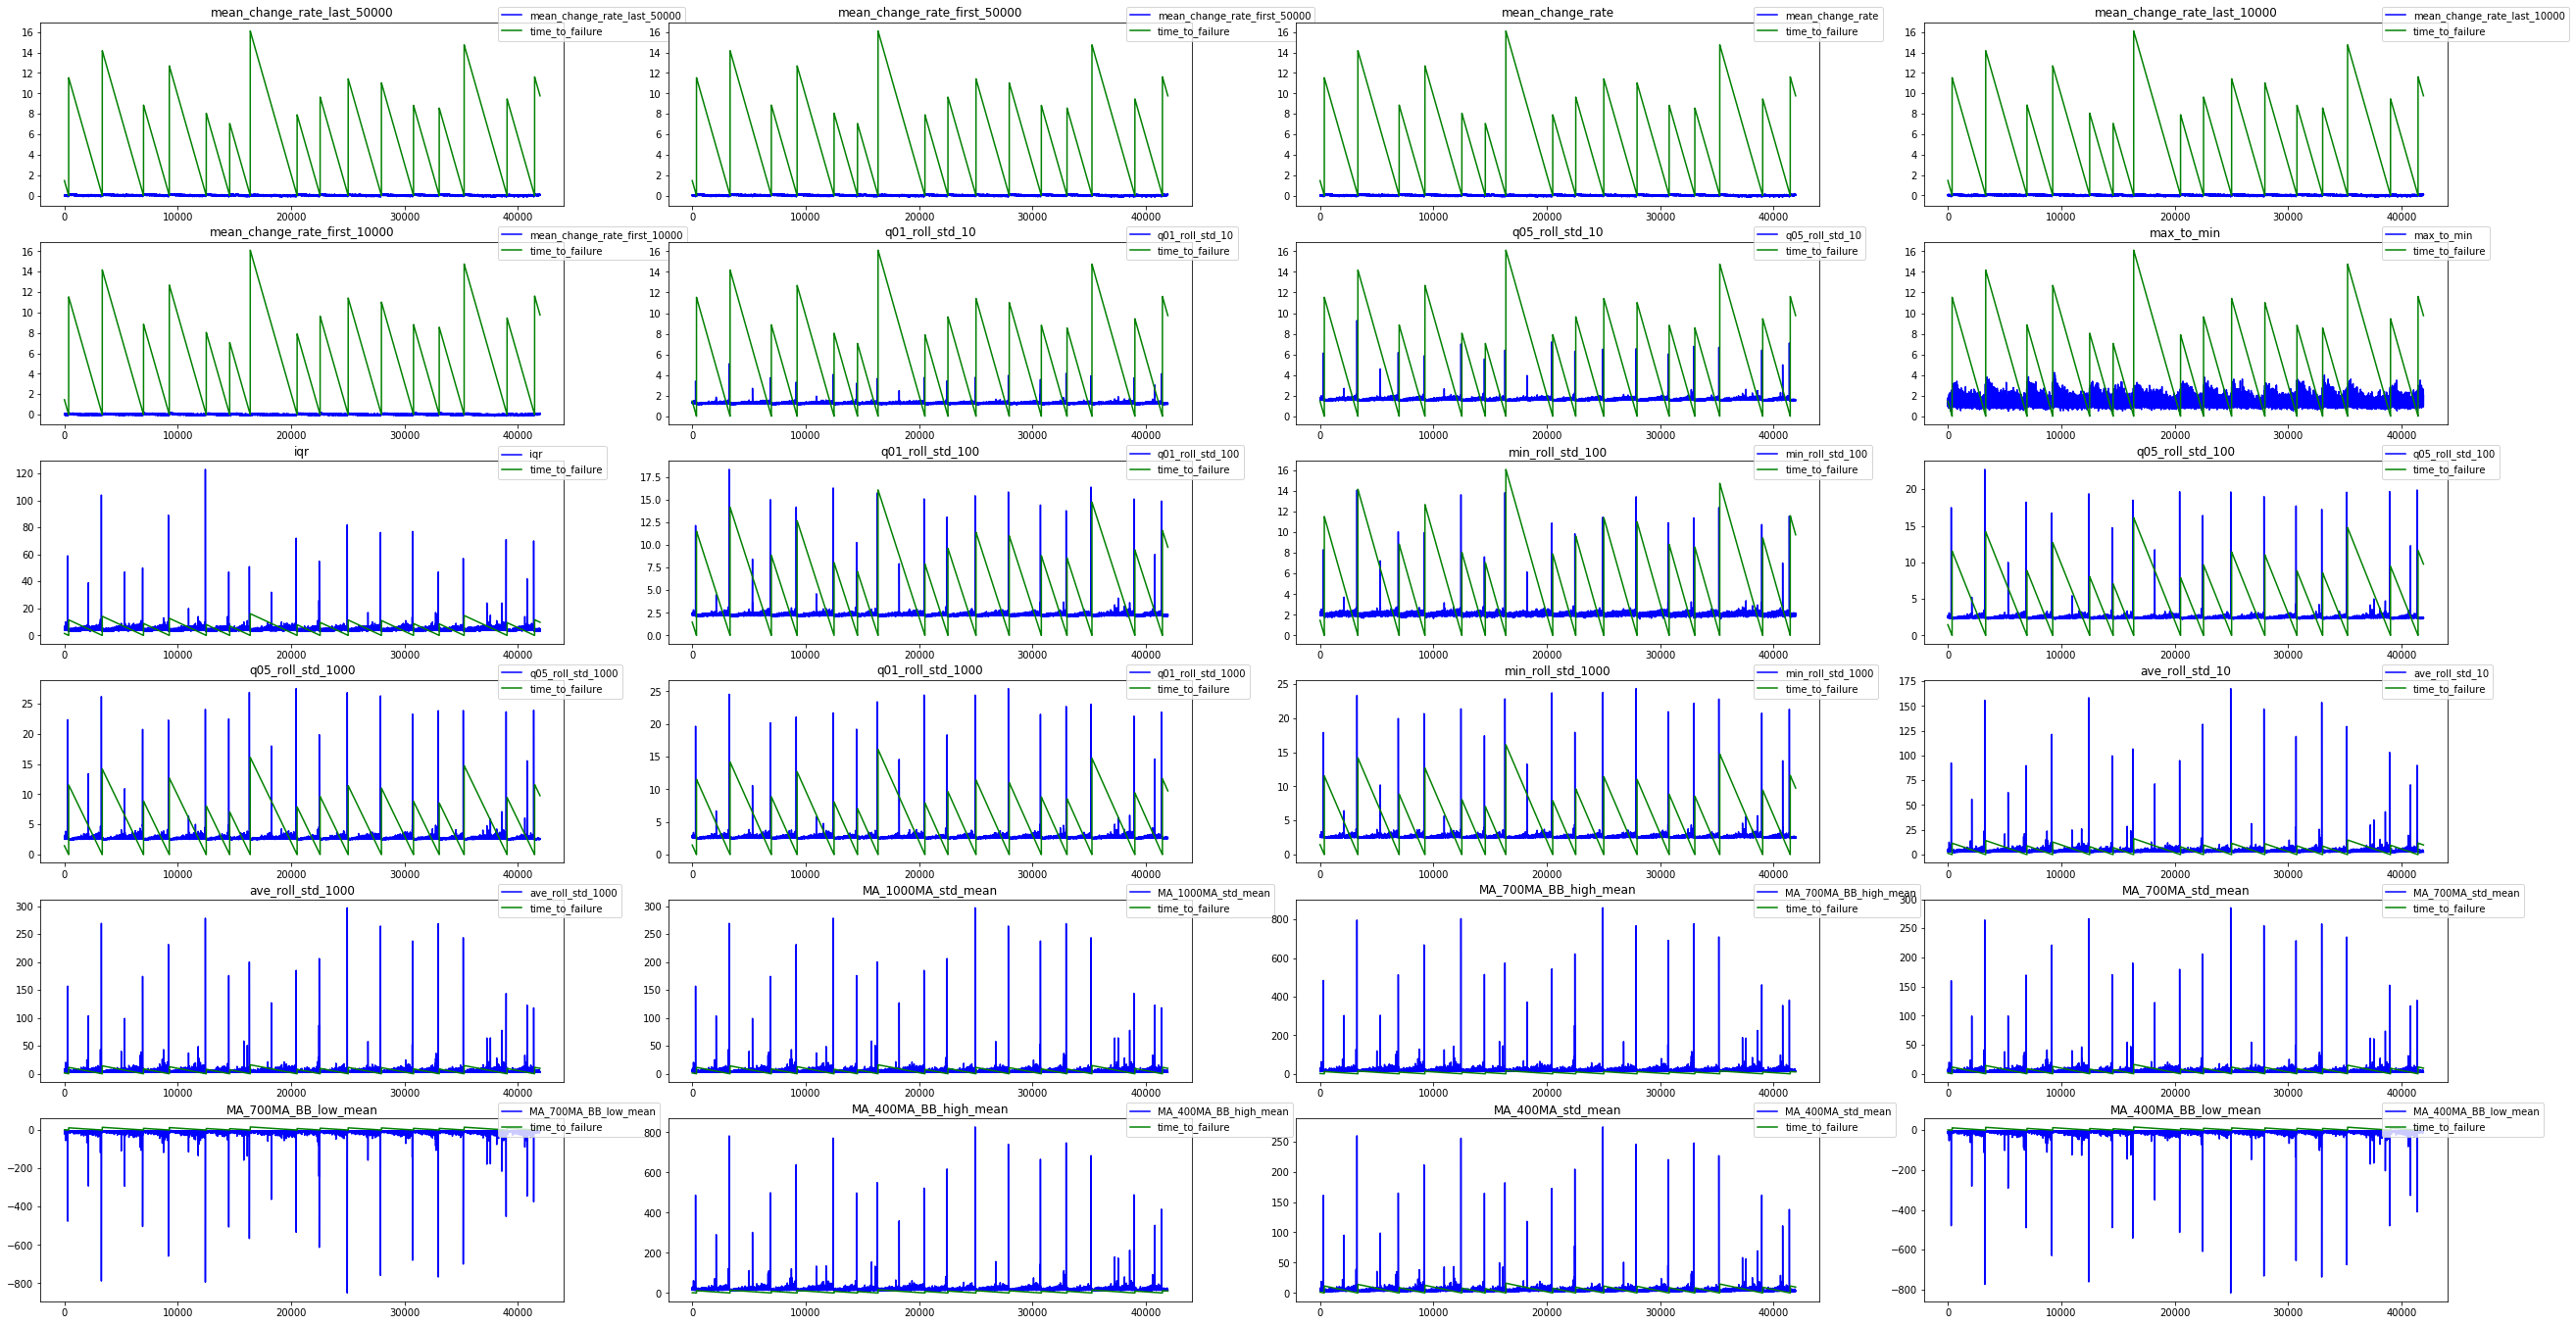

In [25]:
plt.figure(figsize=(44, 24))
cols = list(np.abs(X_tr.corrwith(y_tr['time_to_failure'])).sort_values(ascending=False).head(24).index)
for i, col in enumerate(cols):
    plt.subplot(6, 4, i + 1)
    plt.plot(X_tr[col], color='blue')
    plt.title(col)
    ax1.set_ylabel(col, color='b')

    ax2 = ax1.twinx()
    plt.plot(y_tr, color='g')
    ax2.set_ylabel('time_to_failure', color='g')
    plt.legend([col, 'time_to_failure'], loc=(0.875, 0.9))
    plt.grid(False)

In [27]:
means_dict = {}
for col in X_tr.columns:
    if X_tr[col].isnull().any():
        print(col)
        mean_value = X_tr.loc[X_tr[col] != -np.inf, col].mean()
        X_tr.loc[X_tr[col] == -np.inf, col] = mean_value
        X_tr[col] = X_tr[col].fillna(mean_value)
        means_dict[col] = mean_value

classic_sta_lta5_mean
classic_sta_lta7_mean


In [28]:
scaler = StandardScaler()
scaler.fit(X_tr)
X_train_scaled = pd.DataFrame(scaler.transform(X_tr), columns=X_tr.columns)

In [29]:
seg_chunk_len = 15000
chunks_num = 10
file_num = 20

In [30]:
submission = pd.read_csv('../input/sample_submission.csv', index_col='seg_id')

In [31]:
X_test = pd.DataFrame(columns=X_tr.columns, dtype=np.float64, index=range(len(submission.index) * chunks_num))

In [35]:
#submission = pd.read_csv('../input/sample_submission.csv', index_col='test_idx')
#X_test = pd.DataFrame(columns=X_tr.columns, dtype=np.float64, index=submission.index)
plt.figure(figsize=(22, 16))

#for i, test_idx in enumerate(tqdm_notebook(X_test.index)):
#for i, test_idx in enumerate(tqdm_notebook(X_test.index)):
#    seg = pd.read_csv('../input/test/' + test_idx + '.csv')
test_idx = 0
#for i, seg_filename in enumerate(tqdm_notebook(os.listdir('../input/test/'))):
for i, seg_id in enumerate(submission.index.tolist()):
    seg_df = pd.read_csv('../input/test/{}.csv'.format(seg_id))
    #test_idx = seg_filename[:-4]
    x = pd.Series(seg_df['acoustic_data'].values)
    for chunk_idx in range(chunks_num):
        x_chunk = x[chunk_idx * seg_chunk_len:(chunk_idx + 1) * seg_chunk_len]
        X_test.loc[test_idx]['seg_id'] = seg_id
        X_test.loc[test_idx]['mean'] = x_chunk.mean()
        X_test.loc[test_idx]['std'] = x_chunk.std()    
    
        X_test.loc[test_idx]['mean'] = x_chunk.mean()
        X_test.loc[test_idx]['std'] = x_chunk.std()
        X_test.loc[test_idx]['max'] = x_chunk.max()
        X_test.loc[test_idx]['min'] = x_chunk.min()
        
        X_test.loc[test_idx]['mean_change_abs'] = np.mean(np.diff(x))
        X_test.loc[test_idx]['mean_change_rate'] = calc_change_rate(x)
        X_test.loc[test_idx]['abs_max'] = np.abs(x).max()
        X_test.loc[test_idx]['abs_min'] = np.abs(x).min()
    
        X_test.loc[test_idx]['std_first_50000'] = x_chunk[:50000].std()
        X_test.loc[test_idx]['std_last_50000'] = x_chunk[-50000:].std()
        X_test.loc[test_idx]['std_first_10000'] = x_chunk[:10000].std()
        X_test.loc[test_idx]['std_last_10000'] = x_chunk[-10000:].std()
    
        X_test.loc[test_idx]['avg_first_50000'] = x_chunk[:50000].mean()
        X_test.loc[test_idx]['avg_last_50000'] = x_chunk[-50000:].mean()
        X_test.loc[test_idx]['avg_first_10000'] = x_chunk[:10000].mean()
        X_test.loc[test_idx]['avg_last_10000'] = x_chunk[-10000:].mean()
    
        X_test.loc[test_idx]['min_first_50000'] = x_chunk[:50000].min()
        X_test.loc[test_idx]['min_last_50000'] = x_chunk[-50000:].min()
        X_test.loc[test_idx]['min_first_10000'] = x_chunk[:10000].min()
        X_test.loc[test_idx]['min_last_10000'] = x_chunk[-10000:].min()
    
        X_test.loc[test_idx]['max_first_50000'] = x_chunk[:50000].max()
        X_test.loc[test_idx]['max_last_50000'] = x_chunk[-50000:].max()
        X_test.loc[test_idx]['max_first_10000'] = x_chunk[:10000].max()
        X_test.loc[test_idx]['max_last_10000'] = x_chunk[-10000:].max()
        
        X_test.loc[test_idx]['max_to_min'] = x_chunk.max() / np.abs(x_chunk.min())
        X_test.loc[test_idx]['max_to_min_diff'] = x_chunk.max() - np.abs(x_chunk.min())
        X_test.loc[test_idx]['count_big'] = len(x[np.abs(x) > 500])
        X_test.loc[test_idx]['sum'] = x_chunk.sum()
    
        X_test.loc[test_idx]['mean_change_rate_first_50000'] = calc_change_rate(x[:50000])
        X_test.loc[test_idx]['mean_change_rate_last_50000'] = calc_change_rate(x[-50000:])
        X_test.loc[test_idx]['mean_change_rate_first_10000'] = calc_change_rate(x[:10000])
        X_test.loc[test_idx]['mean_change_rate_last_10000'] = calc_change_rate(x[-10000:])
    
        X_test.loc[test_idx]['q95'] = np.quantile(x,0.95)
        X_test.loc[test_idx]['q99'] = np.quantile(x,0.99)
        X_test.loc[test_idx]['q05'] = np.quantile(x,0.05)
        X_test.loc[test_idx]['q01'] = np.quantile(x,0.01)
    
        X_test.loc[test_idx]['abs_q95'] = np.quantile(np.abs(x), 0.95)
        X_test.loc[test_idx]['abs_q99'] = np.quantile(np.abs(x), 0.99)
        X_test.loc[test_idx]['abs_q05'] = np.quantile(np.abs(x), 0.05)
        X_test.loc[test_idx]['abs_q01'] = np.quantile(np.abs(x), 0.01)
    
        X_test.loc[test_idx]['trend'] = add_trend_feature(x)
        X_test.loc[test_idx]['abs_trend'] = add_trend_feature(x, abs_values=True)
        X_test.loc[test_idx]['abs_mean'] = np.abs(x).mean()
        X_test.loc[test_idx]['abs_std'] = np.abs(x).std()
    
        X_test.loc[test_idx]['mad'] = x_chunk.mad()
        X_test.loc[test_idx]['kurt'] = x_chunk.kurtosis()
        X_test.loc[test_idx]['skew'] = x_chunk.skew()
        X_test.loc[test_idx]['med'] = x_chunk.median()
    
        X_test.loc[test_idx]['Hilbert_mean'] = np.abs(hilbert(x)).mean()
        X_test.loc[test_idx]['Hann_window_mean'] = (convolve(x, hann(150), mode='same') / sum(hann(150))).mean()
        X_test.loc[test_idx]['classic_sta_lta1_mean'] = classic_sta_lta(x, 500, 10000).mean()
        X_test.loc[test_idx]['classic_sta_lta2_mean'] = classic_sta_lta(x, 5000, 100000).mean()
        X_test.loc[test_idx]['classic_sta_lta3_mean'] = classic_sta_lta(x, 3333, 6666).mean()
        X_test.loc[test_idx]['classic_sta_lta4_mean'] = classic_sta_lta(x, 10000, 25000).mean()
        X_test.loc[test_idx]['classic_sta_lta5_mean'] = classic_sta_lta(x, 50, 1000).mean()
        X_test.loc[test_idx]['classic_sta_lta6_mean'] = classic_sta_lta(x, 100, 5000).mean()
        X_test.loc[test_idx]['classic_sta_lta7_mean'] = classic_sta_lta(x, 333, 666).mean()
        X_test.loc[test_idx]['classic_sta_lta8_mean'] = classic_sta_lta(x, 4000, 10000).mean()
        X_test.loc[test_idx]['Moving_average_700_mean'] = x_chunk.rolling(window=700).mean().mean(skipna=True)
        ewma = pd.Series.ewm
        X_test.loc[test_idx]['exp_Moving_average_300_mean'] = (ewma(x, span=300).mean()).mean(skipna=True)
        X_test.loc[test_idx]['exp_Moving_average_3000_mean'] = ewma(x, span=3000).mean().mean(skipna=True)
        X_test.loc[test_idx]['exp_Moving_average_30000_mean'] = ewma(x, span=30000).mean().mean(skipna=True)
        no_of_std = 3
        X_test.loc[test_idx]['MA_700MA_std_mean'] = x_chunk.rolling(window=700).std().mean()
        X_test.loc[test_idx,'MA_700MA_BB_high_mean'] = (X_test.loc[test_idx]['Moving_average_700_mean'] + no_of_std * X_test.loc[test_idx]['MA_700MA_std_mean']).mean()
        X_test.loc[test_idx,'MA_700MA_BB_low_mean'] = (X_test.loc[test_idx]['Moving_average_700_mean'] - no_of_std * X_test.loc[test_idx]['MA_700MA_std_mean']).mean()
        X_test.loc[test_idx]['MA_400MA_std_mean'] = x_chunk.rolling(window=400).std().mean()
        X_test.loc[test_idx,'MA_400MA_BB_high_mean'] = (X_test.loc[test_idx]['Moving_average_700_mean'] + no_of_std * X_test.loc[test_idx]['MA_400MA_std_mean']).mean()
        X_test.loc[test_idx,'MA_400MA_BB_low_mean'] = (X_test.loc[test_idx]['Moving_average_700_mean'] - no_of_std * X_test.loc[test_idx]['MA_400MA_std_mean']).mean()
        X_test.loc[test_idx]['MA_1000MA_std_mean'] = x_chunk.rolling(window=1000).std().mean()
        X_test.drop('Moving_average_700_mean', axis=1, inplace=True)
    
        X_test.loc[test_idx]['iqr'] = np.subtract(*np.percentile(x, [75, 25]))
        X_test.loc[test_idx]['q999'] = np.quantile(x,0.999)
        X_test.loc[test_idx]['q001'] = np.quantile(x,0.001)
        X_test.loc[test_idx]['ave10'] = stats.trim_mean(x, 0.1)
    
        for windows in [10, 100, 1000]:
            x_roll_std = x_chunk.rolling(windows).std().dropna().values
            x_roll_mean = x_chunk.rolling(windows).mean().dropna().values
        
            X_test.loc[test_idx]['ave_roll_std_' + str(windows)] = x_roll_std.mean()
            X_test.loc[test_idx]['std_roll_std_' + str(windows)] = x_roll_std.std()
            X_test.loc[test_idx]['max_roll_std_' + str(windows)] = x_roll_std.max()
            X_test.loc[test_idx]['min_roll_std_' + str(windows)] = x_roll_std.min()
            X_test.loc[test_idx]['q01_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.01)
            X_test.loc[test_idx]['q05_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.05)
            X_test.loc[test_idx]['q95_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.95)
            X_test.loc[test_idx]['q99_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.99)
            X_test.loc[test_idx]['av_change_abs_roll_std_' + str(windows)] = np.mean(np.diff(x_roll_std))
            X_test.loc[test_idx]['av_change_rate_roll_std_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_std) / x_roll_std[:-1]))[0])
            X_test.loc[test_idx]['abs_max_roll_std_' + str(windows)] = np.abs(x_roll_std).max()
        
            X_test.loc[test_idx]['ave_roll_mean_' + str(windows)] = x_roll_mean.mean()
            X_test.loc[test_idx]['std_roll_mean_' + str(windows)] = x_roll_mean.std()
            X_test.loc[test_idx]['max_roll_mean_' + str(windows)] = x_roll_mean.max()
            X_test.loc[test_idx]['min_roll_mean_' + str(windows)] = x_roll_mean.min()
            X_test.loc[test_idx]['q01_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.01)
            X_test.loc[test_idx]['q05_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.05)
            X_test.loc[test_idx]['q95_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.95)
            X_test.loc[test_idx]['q99_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.99)
            X_test.loc[test_idx]['av_change_abs_roll_mean_' + str(windows)] = np.mean(np.diff(x_roll_mean))
            X_test.loc[test_idx]['av_change_rate_roll_mean_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_mean) / x_roll_mean[:-1]))[0])
            X_test.loc[test_idx]['abs_max_roll_mean_' + str(windows)] = np.abs(x_roll_mean).max()
        test_idx += 1
        if i < 12:
            plt.subplot(6, 4, i + 1)
            plt.plot(seg['acoustic_data'])
            plt.title(seg_id)

for col in X_test.columns:
    if X_test[col].isnull().any():
        X_test.loc[X_test[col] == -np.inf, col] = means_dict[col]
        X_test[col] = X_test[col].fillna(means_dict[col])
        
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

KeyError: 'Moving_average_700_mean'

<Figure size 1584x1152 with 0 Axes>

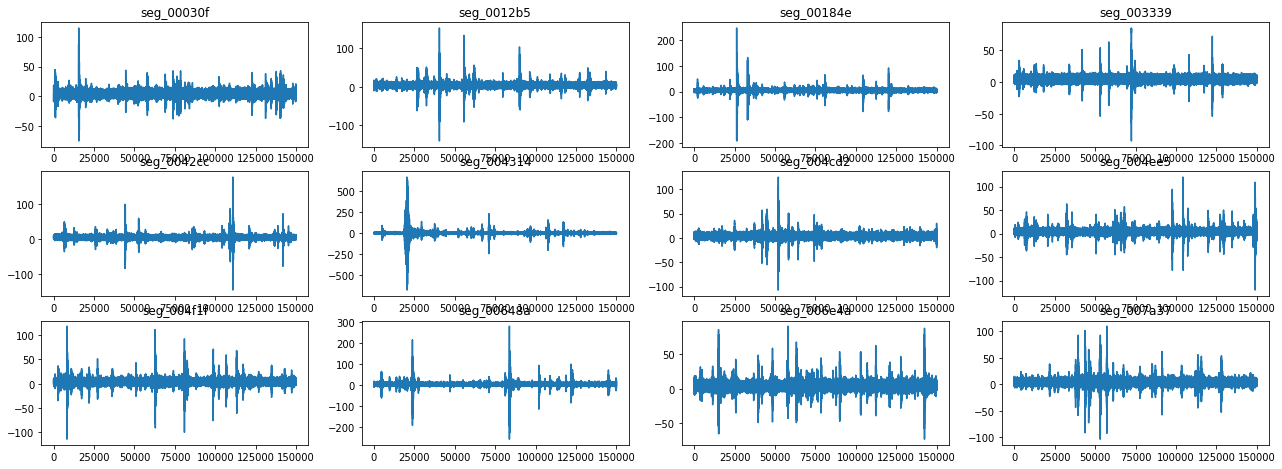

In [36]:
submission = pd.read_csv('../input/sample_submission.csv', index_col='seg_id')
X_test = pd.DataFrame(columns=X_tr.columns, dtype=np.float64, index=submission.index)
plt.figure(figsize=(22, 16))

for i, seg_id in enumerate(tqdm_notebook(X_test.index)):
    seg = pd.read_csv('../input/test/' + seg_id + '.csv')
    
    x = pd.Series(seg['acoustic_data'].values)
    X_test.loc[seg_id, 'mean'] = x.mean()
    X_test.loc[seg_id, 'std'] = x.std()
    X_test.loc[seg_id, 'max'] = x.max()
    X_test.loc[seg_id, 'min'] = x.min()
        
    X_test.loc[seg_id, 'mean_change_abs'] = np.mean(np.diff(x))
    X_test.loc[seg_id, 'mean_change_rate'] = calc_change_rate(x)
    X_test.loc[seg_id, 'abs_max'] = np.abs(x).max()
    X_test.loc[seg_id, 'abs_min'] = np.abs(x).min()
    
    X_test.loc[seg_id, 'std_first_50000'] = x[:50000].std()
    X_test.loc[seg_id, 'std_last_50000'] = x[-50000:].std()
    X_test.loc[seg_id, 'std_first_10000'] = x[:10000].std()
    X_test.loc[seg_id, 'std_last_10000'] = x[-10000:].std()
    
    X_test.loc[seg_id, 'avg_first_50000'] = x[:50000].mean()
    X_test.loc[seg_id, 'avg_last_50000'] = x[-50000:].mean()
    X_test.loc[seg_id, 'avg_first_10000'] = x[:10000].mean()
    X_test.loc[seg_id, 'avg_last_10000'] = x[-10000:].mean()
    
    X_test.loc[seg_id, 'min_first_50000'] = x[:50000].min()
    X_test.loc[seg_id, 'min_last_50000'] = x[-50000:].min()
    X_test.loc[seg_id, 'min_first_10000'] = x[:10000].min()
    X_test.loc[seg_id, 'min_last_10000'] = x[-10000:].min()
    
    X_test.loc[seg_id, 'max_first_50000'] = x[:50000].max()
    X_test.loc[seg_id, 'max_last_50000'] = x[-50000:].max()
    X_test.loc[seg_id, 'max_first_10000'] = x[:10000].max()
    X_test.loc[seg_id, 'max_last_10000'] = x[-10000:].max()
    
    X_test.loc[seg_id, 'max_to_min'] = x.max() / np.abs(x.min())
    X_test.loc[seg_id, 'max_to_min_diff'] = x.max() - np.abs(x.min())
    X_test.loc[seg_id, 'count_big'] = len(x[np.abs(x) > 500])
    X_test.loc[seg_id, 'sum'] = x.sum()
    
    X_test.loc[seg_id, 'mean_change_rate_first_50000'] = calc_change_rate(x[:50000])
    X_test.loc[seg_id, 'mean_change_rate_last_50000'] = calc_change_rate(x[-50000:])
    X_test.loc[seg_id, 'mean_change_rate_first_10000'] = calc_change_rate(x[:10000])
    X_test.loc[seg_id, 'mean_change_rate_last_10000'] = calc_change_rate(x[-10000:])
    
    X_test.loc[seg_id, 'q95'] = np.quantile(x,0.95)
    X_test.loc[seg_id, 'q99'] = np.quantile(x,0.99)
    X_test.loc[seg_id, 'q05'] = np.quantile(x,0.05)
    X_test.loc[seg_id, 'q01'] = np.quantile(x,0.01)
    
    X_test.loc[seg_id, 'abs_q95'] = np.quantile(np.abs(x), 0.95)
    X_test.loc[seg_id, 'abs_q99'] = np.quantile(np.abs(x), 0.99)
    X_test.loc[seg_id, 'abs_q05'] = np.quantile(np.abs(x), 0.05)
    X_test.loc[seg_id, 'abs_q01'] = np.quantile(np.abs(x), 0.01)
    
    X_test.loc[seg_id, 'trend'] = add_trend_feature(x)
    X_test.loc[seg_id, 'abs_trend'] = add_trend_feature(x, abs_values=True)
    X_test.loc[seg_id, 'abs_mean'] = np.abs(x).mean()
    X_test.loc[seg_id, 'abs_std'] = np.abs(x).std()
    
    X_test.loc[seg_id, 'mad'] = x.mad()
    X_test.loc[seg_id, 'kurt'] = x.kurtosis()
    X_test.loc[seg_id, 'skew'] = x.skew()
    X_test.loc[seg_id, 'med'] = x.median()
    
    X_test.loc[seg_id, 'Hilbert_mean'] = np.abs(hilbert(x)).mean()
    X_test.loc[seg_id, 'Hann_window_mean'] = (convolve(x, hann(150), mode='same') / sum(hann(150))).mean()
    X_test.loc[seg_id, 'classic_sta_lta1_mean'] = classic_sta_lta(x, 500, 10000).mean()
    X_test.loc[seg_id, 'classic_sta_lta2_mean'] = classic_sta_lta(x, 5000, 100000).mean()
    X_test.loc[seg_id, 'classic_sta_lta3_mean'] = classic_sta_lta(x, 3333, 6666).mean()
    X_test.loc[seg_id, 'classic_sta_lta4_mean'] = classic_sta_lta(x, 10000, 25000).mean()
    X_test.loc[seg_id, 'classic_sta_lta5_mean'] = classic_sta_lta(x, 50, 1000).mean()
    X_test.loc[seg_id, 'classic_sta_lta6_mean'] = classic_sta_lta(x, 100, 5000).mean()
    X_test.loc[seg_id, 'classic_sta_lta7_mean'] = classic_sta_lta(x, 333, 666).mean()
    X_test.loc[seg_id, 'classic_sta_lta8_mean'] = classic_sta_lta(x, 4000, 10000).mean()
    X_test.loc[seg_id, 'Moving_average_700_mean'] = x.rolling(window=700).mean().mean(skipna=True)
    ewma = pd.Series.ewm
    X_test.loc[seg_id, 'exp_Moving_average_300_mean'] = (ewma(x, span=300).mean()).mean(skipna=True)
    X_test.loc[seg_id, 'exp_Moving_average_3000_mean'] = ewma(x, span=3000).mean().mean(skipna=True)
    X_test.loc[seg_id, 'exp_Moving_average_30000_mean'] = ewma(x, span=30000).mean().mean(skipna=True)
    no_of_std = 3
    X_test.loc[seg_id, 'MA_700MA_std_mean'] = x.rolling(window=700).std().mean()
    X_test.loc[seg_id,'MA_700MA_BB_high_mean'] = (X_test.loc[seg_id, 'Moving_average_700_mean'] + no_of_std * X_test.loc[seg_id, 'MA_700MA_std_mean']).mean()
    X_test.loc[seg_id,'MA_700MA_BB_low_mean'] = (X_test.loc[seg_id, 'Moving_average_700_mean'] - no_of_std * X_test.loc[seg_id, 'MA_700MA_std_mean']).mean()
    X_test.loc[seg_id, 'MA_400MA_std_mean'] = x.rolling(window=400).std().mean()
    X_test.loc[seg_id,'MA_400MA_BB_high_mean'] = (X_test.loc[seg_id, 'Moving_average_700_mean'] + no_of_std * X_test.loc[seg_id, 'MA_400MA_std_mean']).mean()
    X_test.loc[seg_id,'MA_400MA_BB_low_mean'] = (X_test.loc[seg_id, 'Moving_average_700_mean'] - no_of_std * X_test.loc[seg_id, 'MA_400MA_std_mean']).mean()
    X_test.loc[seg_id, 'MA_1000MA_std_mean'] = x.rolling(window=1000).std().mean()
    X_test.drop('Moving_average_700_mean', axis=1, inplace=True)
    
    X_test.loc[seg_id, 'iqr'] = np.subtract(*np.percentile(x, [75, 25]))
    X_test.loc[seg_id, 'q999'] = np.quantile(x,0.999)
    X_test.loc[seg_id, 'q001'] = np.quantile(x,0.001)
    X_test.loc[seg_id, 'ave10'] = stats.trim_mean(x, 0.1)
    
    for windows in [10, 100, 1000]:
        x_roll_std = x.rolling(windows).std().dropna().values
        x_roll_mean = x.rolling(windows).mean().dropna().values
        
        X_test.loc[seg_id, 'ave_roll_std_' + str(windows)] = x_roll_std.mean()
        X_test.loc[seg_id, 'std_roll_std_' + str(windows)] = x_roll_std.std()
        X_test.loc[seg_id, 'max_roll_std_' + str(windows)] = x_roll_std.max()
        X_test.loc[seg_id, 'min_roll_std_' + str(windows)] = x_roll_std.min()
        X_test.loc[seg_id, 'q01_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.01)
        X_test.loc[seg_id, 'q05_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.05)
        X_test.loc[seg_id, 'q95_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.95)
        X_test.loc[seg_id, 'q99_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.99)
        X_test.loc[seg_id, 'av_change_abs_roll_std_' + str(windows)] = np.mean(np.diff(x_roll_std))
        X_test.loc[seg_id, 'av_change_rate_roll_std_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_std) / x_roll_std[:-1]))[0])
        X_test.loc[seg_id, 'abs_max_roll_std_' + str(windows)] = np.abs(x_roll_std).max()
        
        X_test.loc[seg_id, 'ave_roll_mean_' + str(windows)] = x_roll_mean.mean()
        X_test.loc[seg_id, 'std_roll_mean_' + str(windows)] = x_roll_mean.std()
        X_test.loc[seg_id, 'max_roll_mean_' + str(windows)] = x_roll_mean.max()
        X_test.loc[seg_id, 'min_roll_mean_' + str(windows)] = x_roll_mean.min()
        X_test.loc[seg_id, 'q01_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.01)
        X_test.loc[seg_id, 'q05_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.05)
        X_test.loc[seg_id, 'q95_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.95)
        X_test.loc[seg_id, 'q99_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.99)
        X_test.loc[seg_id, 'av_change_abs_roll_mean_' + str(windows)] = np.mean(np.diff(x_roll_mean))
        X_test.loc[seg_id, 'av_change_rate_roll_mean_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_mean) / x_roll_mean[:-1]))[0])
        X_test.loc[seg_id, 'abs_max_roll_mean_' + str(windows)] = np.abs(x_roll_mean).max()
    
    if i < 12:
        plt.subplot(6, 4, i + 1)
        plt.plot(seg['acoustic_data'])
        plt.title(seg_id)

for col in X_test.columns:
    if X_test[col].isnull().any():
        X_test.loc[X_test[col] == -np.inf, col] = means_dict[col]
        X_test[col] = X_test[col].fillna(means_dict[col])
        
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [37]:
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=11)

In [38]:
def train_model(
    X=X_train_scaled,
    X_test=X_test_scaled,
    y=y_tr,
    params=None,
    folds=folds,
    model_type='lgb',
    plot_feature_importance=False,
    model=None
):

    oof = np.zeros(len(X))
    prediction = np.zeros(len(X_test))
    scores = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print('Fold', fold_n, 'started at', time.ctime())
        X_train = X.iloc[train_index]
        X_valid = X.iloc[valid_index]
        y_train = (y.iloc[train_index].values).ravel()
        y_valid = (y.iloc[valid_index].values).ravel()
        print("type(y_train):", type(y_train))
        print("y_train.shape:", y_train.shape)
        print("type(y_vaid):", type(y_valid))
        print("y_valid.shape:", y_valid.shape)
        
        if model_type == 'lgb':
            model = lgb.LGBMRegressor(**params, n_estimators = 50000, n_jobs = -1)
            model.fit(
                X_train,
                y_train,
                eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='mae', 
                verbose=10000,
                early_stopping_rounds=200
            )            
            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(
                dtrain=train_data,
                num_boost_round=20000,
                evals=watchlist,
                early_stopping_rounds=200,
                verbose_eval=500,
                params=params
            )
            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
        
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            
            y_pred_valid = model.predict(X_valid).reshape(-1,)
            score = mean_absolute_error(y_valid, y_pred_valid)
            print(f'Fold {fold_n}. MAE: {score:.4f}.')
            print('')
            
            y_pred = model.predict(X_test).reshape(-1,)
        
        if model_type == 'cat':
            model = CatBoostRegressor(iterations=20000,  eval_metric='MAE', **params)
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test)
        
        oof[valid_index] = y_pred_valid.reshape(-1,)
        scores.append(mean_absolute_error(y_valid, y_pred_valid))

        prediction += y_pred    
        
        if model_type == 'lgb':
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X.columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_fold
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    if model_type == 'lgb':
        feature_importance["importance"] /= n_fold
        if plot_feature_importance:
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
        
            return oof, prediction, feature_importance
        return oof, prediction
    
    else:
        return oof, prediction

Fold 0 started at Tue May 21 13:58:11 2019
type(y_train): <class 'numpy.ndarray'>
y_train.shape: (33554,)
type(y_vaid): <class 'numpy.ndarray'>
y_valid.shape: (8389,)
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1365]	training's l1: 1.97025	valid_1's l1: 2.33504
Fold 1 started at Tue May 21 15:21:47 2019
type(y_train): <class 'numpy.ndarray'>
y_train.shape: (33554,)
type(y_vaid): <class 'numpy.ndarray'>
y_valid.shape: (8389,)
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1471]	training's l1: 1.94744	valid_1's l1: 2.33086
Fold 2 started at Tue May 21 16:50:53 2019
type(y_train): <class 'numpy.ndarray'>
y_train.shape: (33554,)
type(y_vaid): <class 'numpy.ndarray'>
y_valid.shape: (8389,)
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1455]	training's l1: 1.9602	valid_1's l1: 2.29392
Fold 3 started at Tue May 21 18:20:09 2019
type(y_

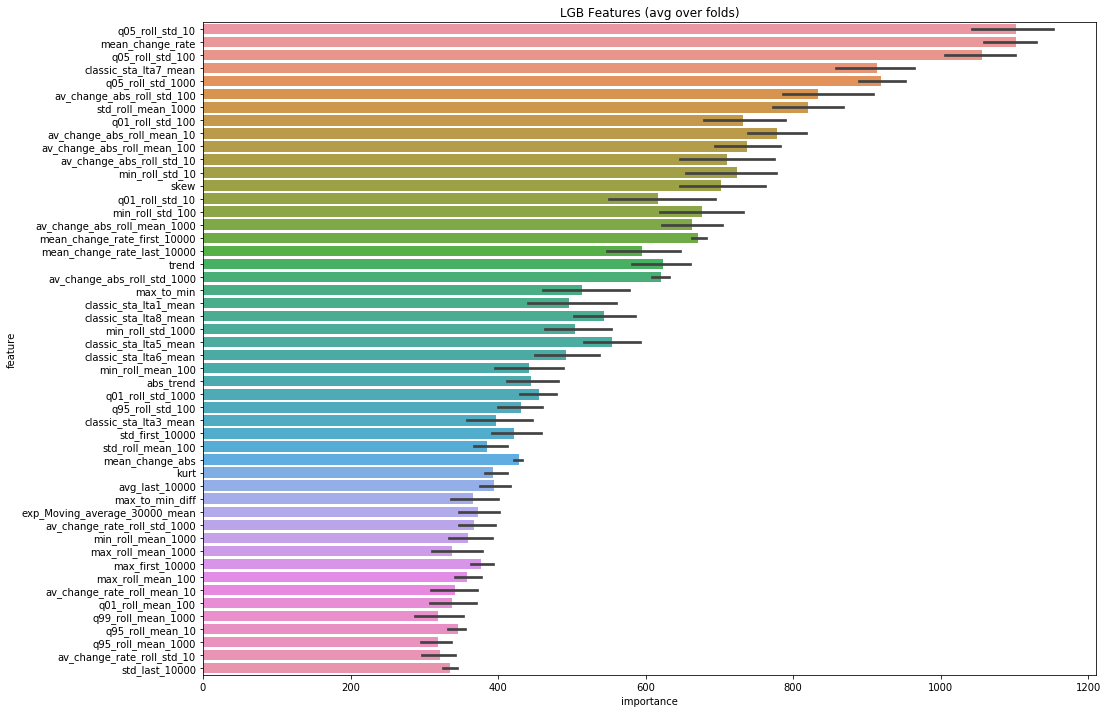

In [39]:
%%time
params = {'num_leaves': 128,
          'min_data_in_leaf': 79,
          'objective': 'huber',
          'max_depth': -1,
          'learning_rate': 0.01,
          "boosting": "gbdt",
          "bagging_freq": 5,
          "bagging_fraction": 0.8126672064208567,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1302650970728192,
          'reg_lambda': 0.3603427518866501
         }
oof_lgb, prediction_lgb, feature_importance = train_model(params=params, model_type='lgb', plot_feature_importance=True)

In [40]:
top_cols = list(feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index)

In [41]:
%%time
xgb_params = {'eta': 0.03,
              'max_depth': 9,
              'subsample': 0.85,
              'objective': 'reg:linear',
              'eval_metric': 'mae',
              'silent': True,
              'nthread': 4}
oof_xgb, prediction_xgb = train_model(X=X_train_scaled, X_test=X_test_scaled, params=xgb_params, model_type='xgb')

Fold 0 started at Tue May 21 22:29:11 2019
type(y_train): <class 'numpy.ndarray'>
y_train.shape: (33554,)
type(y_vaid): <class 'numpy.ndarray'>
y_valid.shape: (8389,)
[0]	train-mae:5.06396	valid_data-mae:5.05372
Multiple eval metrics have been passed: 'valid_data-mae' will be used for early stopping.

Will train until valid_data-mae hasn't improved in 200 rounds.
Stopping. Best iteration:
[92]	train-mae:1.89824	valid_data-mae:2.35635

Fold 1 started at Tue May 21 22:30:14 2019
type(y_train): <class 'numpy.ndarray'>
y_train.shape: (33554,)
type(y_vaid): <class 'numpy.ndarray'>
y_valid.shape: (8389,)
[0]	train-mae:5.06512	valid_data-mae:5.04945
Multiple eval metrics have been passed: 'valid_data-mae' will be used for early stopping.

Will train until valid_data-mae hasn't improved in 200 rounds.
Stopping. Best iteration:
[90]	train-mae:1.89671	valid_data-mae:2.3532

Fold 2 started at Tue May 21 22:31:19 2019
type(y_train): <class 'numpy.ndarray'>
y_train.shape: (33554,)
type(y_vaid): <cl

In [42]:
%%time
model = NuSVR(gamma='scale', nu=0.9, C=10.0, tol=0.01)
oof_svr, prediction_svr = train_model(X=X_train_scaled, X_test=X_test_scaled, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue May 21 22:51:48 2019
type(y_train): <class 'numpy.ndarray'>
y_train.shape: (33554,)
type(y_vaid): <class 'numpy.ndarray'>
y_valid.shape: (8389,)
Fold 0. MAE: 2.3520.

Fold 1 started at Tue May 21 23:02:10 2019
type(y_train): <class 'numpy.ndarray'>
y_train.shape: (33554,)
type(y_vaid): <class 'numpy.ndarray'>
y_valid.shape: (8389,)
Fold 1. MAE: 2.3437.

Fold 2 started at Tue May 21 23:12:18 2019
type(y_train): <class 'numpy.ndarray'>
y_train.shape: (33554,)
type(y_vaid): <class 'numpy.ndarray'>
y_valid.shape: (8389,)
Fold 2. MAE: 2.3031.

Fold 3 started at Tue May 21 23:23:03 2019
type(y_train): <class 'numpy.ndarray'>
y_train.shape: (33555,)
type(y_vaid): <class 'numpy.ndarray'>
y_valid.shape: (8388,)
Fold 3. MAE: 2.3349.

Fold 4 started at Tue May 21 23:34:06 2019
type(y_train): <class 'numpy.ndarray'>
y_train.shape: (33555,)
type(y_vaid): <class 'numpy.ndarray'>
y_valid.shape: (8388,)
Fold 4. MAE: 2.3243.

CV mean score: 2.3316, std: 0.0170.
CPU times: user 52m

In [43]:
%%time
model = NuSVR(gamma='scale', nu=0.7, tol=0.01, C=1.0)
oof_svr1, prediction_svr1 = train_model(X=X_train_scaled, X_test=X_test_scaled, params=None, model_type='sklearn', model=model)

Fold 0 started at Wed May 22 00:13:49 2019
type(y_train): <class 'numpy.ndarray'>
y_train.shape: (33554,)
type(y_vaid): <class 'numpy.ndarray'>
y_valid.shape: (8389,)
Fold 0. MAE: 2.3486.

Fold 1 started at Wed May 22 00:21:33 2019
type(y_train): <class 'numpy.ndarray'>
y_train.shape: (33554,)
type(y_vaid): <class 'numpy.ndarray'>
y_valid.shape: (8389,)
Fold 1. MAE: 2.3454.

Fold 2 started at Wed May 22 00:29:12 2019
type(y_train): <class 'numpy.ndarray'>
y_train.shape: (33554,)
type(y_vaid): <class 'numpy.ndarray'>
y_valid.shape: (8389,)
Fold 2. MAE: 2.2996.

Fold 3 started at Wed May 22 00:36:44 2019
type(y_train): <class 'numpy.ndarray'>
y_train.shape: (33555,)
type(y_vaid): <class 'numpy.ndarray'>
y_valid.shape: (8388,)
Fold 3. MAE: 2.3308.

Fold 4 started at Wed May 22 00:44:31 2019
type(y_train): <class 'numpy.ndarray'>
y_train.shape: (33555,)
type(y_vaid): <class 'numpy.ndarray'>
y_valid.shape: (8388,)
Fold 4. MAE: 2.3252.

CV mean score: 2.3299, std: 0.0175.
CPU times: user 38m

In [44]:
%%time
params = {'loss_function':'MAE'}
oof_cat, prediction_cat = train_model(X=X_train_scaled, X_test=X_test_scaled, params=params, model_type='cat')

Fold 0 started at Wed May 22 00:52:05 2019
type(y_train): <class 'numpy.ndarray'>
y_train.shape: (33554,)
type(y_vaid): <class 'numpy.ndarray'>
y_valid.shape: (8389,)
Fold 1 started at Wed May 22 01:18:38 2019
type(y_train): <class 'numpy.ndarray'>
y_train.shape: (33554,)
type(y_vaid): <class 'numpy.ndarray'>
y_valid.shape: (8389,)
Fold 2 started at Wed May 22 01:45:22 2019
type(y_train): <class 'numpy.ndarray'>
y_train.shape: (33554,)
type(y_vaid): <class 'numpy.ndarray'>
y_valid.shape: (8389,)
Fold 3 started at Wed May 22 02:12:11 2019
type(y_train): <class 'numpy.ndarray'>
y_train.shape: (33555,)
type(y_vaid): <class 'numpy.ndarray'>
y_valid.shape: (8388,)
Fold 4 started at Wed May 22 02:39:37 2019
type(y_train): <class 'numpy.ndarray'>
y_train.shape: (33555,)
type(y_vaid): <class 'numpy.ndarray'>
y_valid.shape: (8388,)
CV mean score: 2.3099, std: 0.0149.
CPU times: user 2d 12h 5min 53s, sys: 1h 1min 56s, total: 2d 13h 7min 49s
Wall time: 2h 15min 2s


In [45]:
%%time
model = KernelRidge(kernel='rbf', alpha=0.1, gamma=0.01)
oof_r, prediction_r = train_model(X=X_train_scaled, X_test=X_test_scaled, params=None, model_type='sklearn', model=model)

Fold 0 started at Wed May 22 03:07:07 2019
type(y_train): <class 'numpy.ndarray'>
y_train.shape: (33554,)
type(y_vaid): <class 'numpy.ndarray'>
y_valid.shape: (8389,)
Fold 0. MAE: 2.3955.

Fold 1 started at Wed May 22 03:10:12 2019
type(y_train): <class 'numpy.ndarray'>
y_train.shape: (33554,)
type(y_vaid): <class 'numpy.ndarray'>
y_valid.shape: (8389,)
Fold 1. MAE: 2.3811.

Fold 2 started at Wed May 22 03:13:09 2019
type(y_train): <class 'numpy.ndarray'>
y_train.shape: (33554,)
type(y_vaid): <class 'numpy.ndarray'>
y_valid.shape: (8389,)
Fold 2. MAE: 2.3493.

Fold 3 started at Wed May 22 03:16:09 2019
type(y_train): <class 'numpy.ndarray'>
y_train.shape: (33555,)
type(y_vaid): <class 'numpy.ndarray'>
y_valid.shape: (8388,)
Fold 3. MAE: 2.3760.

Fold 4 started at Wed May 22 03:19:09 2019
type(y_train): <class 'numpy.ndarray'>
y_train.shape: (33555,)
type(y_vaid): <class 'numpy.ndarray'>
y_valid.shape: (8388,)
Fold 4. MAE: 2.3594.

CV mean score: 2.3723, std: 0.0163.
CPU times: user 1h 

In [46]:
train_stack = np.vstack([oof_lgb, oof_xgb, oof_svr, oof_svr1, oof_r, oof_cat]).transpose()
train_stack = pd.DataFrame(train_stack, columns = ['lgb', 'xgb', 'svr', 'svr1', 'r', 'cat'])
test_stack = np.vstack([prediction_lgb, prediction_xgb, prediction_svr, prediction_svr1, prediction_r, prediction_cat]).transpose()
test_stack = pd.DataFrame(test_stack)

Fold 0 started at Wed May 22 03:22:07 2019
type(y_train): <class 'numpy.ndarray'>
y_train.shape: (33554,)
type(y_vaid): <class 'numpy.ndarray'>
y_valid.shape: (8389,)
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[63]	training's l1: 2.2713	valid_1's l1: 2.35732
Fold 1 started at Wed May 22 03:22:07 2019
type(y_train): <class 'numpy.ndarray'>
y_train.shape: (33554,)
type(y_vaid): <class 'numpy.ndarray'>
y_valid.shape: (8389,)
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[48]	training's l1: 2.28302	valid_1's l1: 2.35607
Fold 2 started at Wed May 22 03:22:08 2019
type(y_train): <class 'numpy.ndarray'>
y_train.shape: (33554,)
type(y_vaid): <class 'numpy.ndarray'>
y_valid.shape: (8389,)
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[46]	training's l1: 2.2948	valid_1's l1: 2.32217
Fold 3 started at Wed May 22 03:22:08 2019
type(y_train):

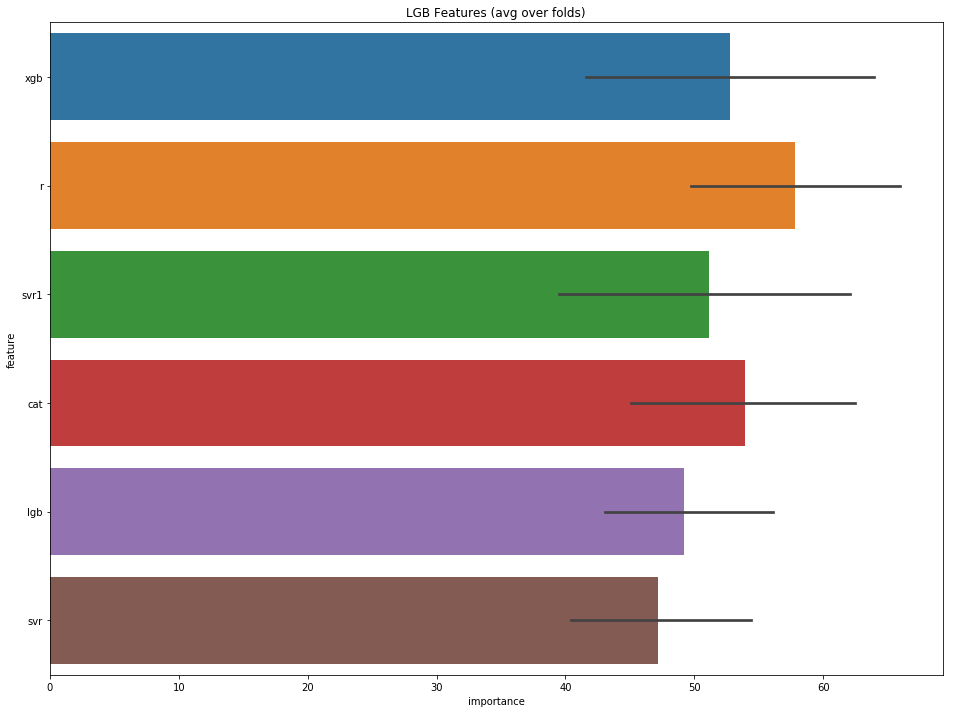

In [47]:
%%time
oof_lgb_stack, prediction_lgb_stack, feature_importance = train_model(X=train_stack, X_test=test_stack, params=params, model_type='lgb', plot_feature_importance=True)

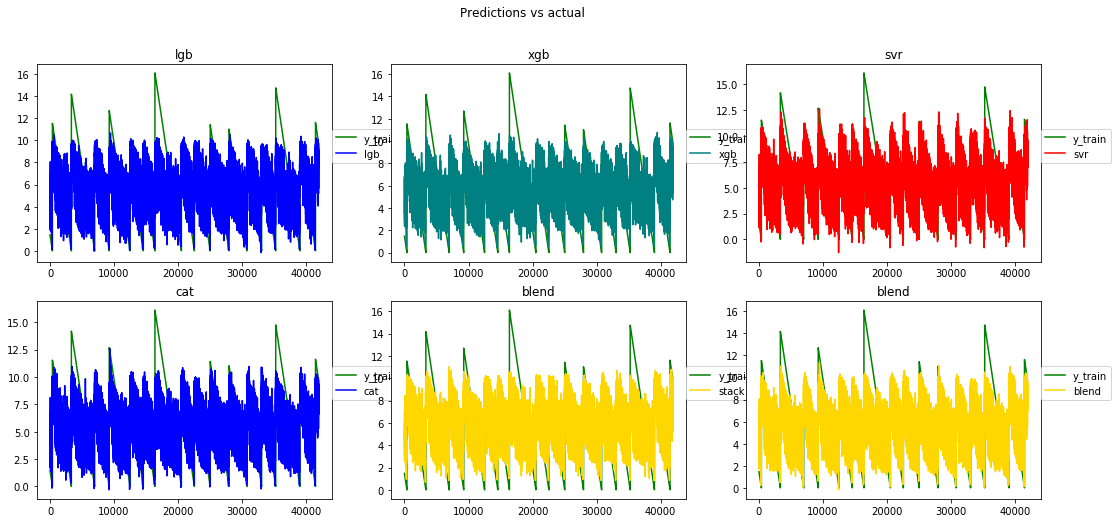

In [48]:
plt.figure(figsize=(18, 8))
plt.subplot(2, 3, 1)
plt.plot(y_tr, color='g', label='y_train')
plt.plot(oof_lgb, color='b', label='lgb')
plt.legend(loc=(1, 0.5));
plt.title('lgb');
plt.subplot(2, 3, 2)
plt.plot(y_tr, color='g', label='y_train')
plt.plot(oof_xgb, color='teal', label='xgb')
plt.legend(loc=(1, 0.5));
plt.title('xgb');
plt.subplot(2, 3, 3)
plt.plot(y_tr, color='g', label='y_train')
plt.plot(oof_svr, color='red', label='svr')
plt.legend(loc=(1, 0.5));
plt.title('svr');
plt.subplot(2, 3, 4)
plt.plot(y_tr, color='g', label='y_train')
plt.plot(oof_cat, color='b', label='cat')
plt.legend(loc=(1, 0.5));
plt.title('cat');
plt.subplot(2, 3, 5)
plt.plot(y_tr, color='g', label='y_train')
plt.plot(oof_lgb_stack, color='gold', label='stack')
plt.legend(loc=(1, 0.5));
plt.title('blend');
plt.legend(loc=(1, 0.5));
plt.suptitle('Predictions vs actual');
plt.subplot(2, 3, 6)
plt.plot(y_tr, color='g', label='y_train')
plt.plot((oof_lgb + oof_xgb + oof_svr + oof_svr1 + oof_r + oof_cat) / 6, color='gold', label='blend')
plt.legend(loc=(1, 0.5));
plt.title('blend');
plt.legend(loc=(1, 0.5));
plt.suptitle('Predictions vs actual');

In [ ]:
submission['time_to_failure'] = (prediction_lgb + prediction_xgb + prediction_svr + prediction_svr1 + prediction_cat + prediction_r) / 6
# submission['time_to_failure'] = prediction_lgb_stack
print(submission.head())
submission.to_csv('submission.csv')

In [ ]:
X_tr.to_csv('train_features.csv', index=False)
X_test.to_csv('test_features.csv', index=False)

In [49]:
train_df.at?